## Imports and configurations

In [20]:
# !pip install rotation-forest

In [21]:
# !cp drive/MyDrive/Studia/Intro_to_Data_Science/Data_Science_Project/lib/multi_adaboost_master/multi_AdaBoost.py .

In [22]:
import warnings
warnings.filterwarnings('ignore')

In [23]:
# from google.colab import drive
# drive.mount('/content/drive')

# FILE_PATH = '/content/drive/MyDrive/Studia/Intro_to_Data_Science/Data_Science_Project/'

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from rotation_forest import RotationForestClassifier
from sklearn.ensemble._forest import ForestClassifier, DecisionTreeClassifier
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics

# Loading and cleaning the data

## Dataset 1

In [25]:
dataset1 = pd.read_csv('Dataset1/arrhythmia.data', header = None)
dataset1

,0,1,2,3,4,5,6,7,8,9,...,270,271,272,273,274,275,276,277,278,279
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,8
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,6
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,10
3,55,0,175,94,100,202,380,179,143,28,...,0.0,12.2,-2.2,0.0,0.0,0.4,2.6,34.6,61.6,1
4,75,0,190,80,88,181,360,177,103,-16,...,0.0,13.1,-3.6,0.0,0.0,-0.1,3.9,25.4,62.8,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,53,1,160,70,80,199,382,154,117,-37,...,0.0,4.3,-5.0,0.0,0.0,0.7,0.6,-4.4,-0.5,1
448,37,0,190,85,100,137,361,201,73,86,...,0.0,15.6,-1.6,0.0,0.0,0.4,2.4,38.0,62.4,10
449,36,0,166,68,108,176,365,194,116,-85,...,0.0,16.3,-28.6,0.0,0.0,1.5,1.0,-44.2,-33.2,2
450,32,1,155,55,93,106,386,218,63,54,...,-0.4,12.0,-0.7,0.0,0.0,0.5,2.4,25.0,46.6,1


Checking the columns types and looking for NAN values in dataset1

In [26]:
dataset1.info()

na_values_counter = dataset1.isna().sum()
na_values_counter.where(na_values_counter > 0).dropna()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452 entries, 0 to 451
Columns: 280 entries, 0 to 279
dtypes: float64(120), int64(155), object(5)
memory usage: 988.9+ KB


Series([], dtype: float64)

It means that there are no NAN values.

Looking for potentially not usefull data (for example some index values that would be unique for each row or columns having the same value for every row - not needed during the classification)

In [27]:
unique_counter = dataset1.nunique()

columns_each_row_unique = unique_counter.where(unique_counter == 452).dropna().index
print("Columns with unique value for each row: ", columns_each_row_unique)

columns_with_only_one_value = unique_counter.where(unique_counter == 1).dropna().index
print("Columns with the same value for each row:\n", columns_with_only_one_value, "length: ", len(columns_with_only_one_value))

Columns with unique value for each row:  Int64Index([], dtype='int64')
Columns with the same value for each row:
 Int64Index([19, 67, 69, 83, 131, 132, 139, 141, 143, 145, 151, 156, 157, 164,
            204, 264, 274],
           dtype='int64') length:  17


In [28]:
dataset1[columns_with_only_one_value]

,19,67,69,83,131,132,139,141,143,145,151,156,157,164,204,264,274
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0
448,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0
449,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0
450,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0


There are 17 columns that have the same value for each row, so they won't be useful during the clasification. I will delete them from the table.

In [29]:
dataset1.drop(columns=columns_with_only_one_value, inplace=True)
dataset1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452 entries, 0 to 451
Columns: 263 entries, 0 to 279
dtypes: float64(116), int64(142), object(5)
memory usage: 928.8+ KB


Now I need to do something with columns of object type, because they cannot be used by classifier.

In [30]:
object_types = dataset1.select_dtypes(include=['object'])

From the dataset column description we know that those data are supposed to be linear and respectively mean: 10 QRS, 11 T, 12 P, 13 QRST, 14 J.

We can suspect that the data is numerical but just the missing data are filled as question marks which may cause problems.

Firstly let's see how many unknown '?' values we have in these columns:

In [31]:
object_types.where(object_types == "?").count()

10      8
11     22
12      1
13    376
14      1
dtype: int64

We can see that in columns 12 and 14 there are just 2 unknown values, so I am going to **delete these rows** because it will not affect our dataset.

In collumn number 11 almost 5% of the data is unknown and in column number 10 ~ 1%, so in these cases I decided to **replace unknown values with mean values** from the columns.

We have total of 452 records in our table, so deleting rows with an unknown value from column 13 would mean loosing 83% of data. So in this case I am going to **delete column number 13** because big majority of data in this column is unknown and replacing this data would lead to wrong conclusions.

In [32]:
# remove records with missing values in columns 12 and 14
dataset1 = dataset1[dataset1[12] != "?"]
dataset1 = dataset1[dataset1[14] != "?"]

# insert mean value of T parameter in columns 10 and 11 where this information is missing
dataset1[dataset1[10] == "?"] = np.nan
dataset1[10] = pd.to_numeric(dataset1[10])
dataset1[dataset1[10].isna()] = dataset1.loc[:,10].mean()

dataset1[dataset1[11] == "?"] = np.nan
dataset1[11] = pd.to_numeric(dataset1[11])
dataset1[dataset1[11].isna()] = dataset1.loc[:,11].mean()


# # remove the column number 13
dataset1.drop(columns=[13], inplace=True)
dataset1

,0,1,2,3,4,5,6,7,8,9,...,269,270,271,272,273,275,276,277,278,279
0,75.0,0.0,190.0,80.0,91.0,193.0,371.0,174.0,121.0,-16.0,...,-0.3,0.0,9.0,-0.9,0.0,0.9,2.9,23.3,49.4,8.0
1,56.0,1.0,165.0,64.0,81.0,174.0,401.0,149.0,39.0,25.0,...,-0.5,0.0,8.5,0.0,0.0,0.2,2.1,20.4,38.8,6.0
2,54.0,0.0,172.0,95.0,138.0,163.0,386.0,185.0,102.0,96.0,...,0.9,0.0,9.5,-2.4,0.0,0.3,3.4,12.3,49.0,10.0
3,55.0,0.0,175.0,94.0,100.0,202.0,380.0,179.0,143.0,28.0,...,0.1,0.0,12.2,-2.2,0.0,0.4,2.6,34.6,61.6,1.0
5,13.0,0.0,169.0,51.0,100.0,167.0,321.0,174.0,91.0,107.0,...,0.0,-0.6,12.2,-2.8,0.0,0.9,2.2,13.5,31.1,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,53.0,1.0,160.0,70.0,80.0,199.0,382.0,154.0,117.0,-37.0,...,0.0,0.0,4.3,-5.0,0.0,0.7,0.6,-4.4,-0.5,1.0
448,37.0,0.0,190.0,85.0,100.0,137.0,361.0,201.0,73.0,86.0,...,-0.5,0.0,15.6,-1.6,0.0,0.4,2.4,38.0,62.4,10.0
449,36.0,0.0,166.0,68.0,108.0,176.0,365.0,194.0,116.0,-85.0,...,1.2,0.0,16.3,-28.6,0.0,1.5,1.0,-44.2,-33.2,2.0
450,32.0,1.0,155.0,55.0,93.0,106.0,386.0,218.0,63.0,54.0,...,0.2,-0.4,12.0,-0.7,0.0,0.5,2.4,25.0,46.6,1.0


In [33]:
dataset1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 450 entries, 0 to 451
Columns: 262 entries, 0 to 279
dtypes: float64(260), object(2)
memory usage: 924.6+ KB


Now all columns are float and there are no unknown values in the table. The dataset is ready to work on.

## Dataset 2

In [34]:
dataset2 = pd.read_csv('Dataset2/AnalizaHRVRhythmDataset.csv', delimiter=";", decimal=",")
dataset2

,Spatial_filling_index_lag_1,Spatial_filling_index_lag_2,Spatial_filling_index_lag_3,Standard_deviation_ratio,Cardiac_sympathetic_index,Correlation_dimension_D2_lag_1,Correlation_dimension_D2_lag_2,Correlation_dimension_D2_lag_3,Central_tendency_measure_lag_1,Central_tendency_measure_lag_2,...,Recurrence_DET_lag_1,Recurrence_DET_lag_2,Recurrence_DET_lag_3,Recurrence_ShEn_lag_1,Recurrence_ShEn_lag_2,Recurrence_ShEn_lag_3,Recurrence_Lam_lag_1,Recurrence_Lam_lag_2,Recurrence_Lam_lag_3,signal_type
0,2.485403,0.000000,0.0,1.594752,0.627057,0,0,0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,PAC
1,5.332129,0.000000,0.0,0.654815,1.527150,0,0,0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,Normal
2,5.381935,0.000000,0.0,0.863627,1.157908,0,0,0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,Normal
3,5.283447,0.000000,0.0,0.700930,1.426676,0,0,0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,Normal
4,5.342012,0.000000,0.0,0.585449,1.708092,0,0,0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8838,3.644247,5.187902,0.0,2.572795,0.388682,0,0,0,0.0,0.0,...,0.327869,0.0,0.0,1.609438,0.0,0.0,0.0,0.0,0.0,PVC
8839,5.809989,5.490799,0.0,0.509318,1.963409,0,0,0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,Normal
8840,3.315160,5.237696,0.0,2.618265,0.381932,0,0,0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,PVC
8841,5.312135,5.872565,0.0,1.448715,0.690267,0,0,0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,Normal


Checking the columns types and looking for NAN values in dataset1

In [35]:
dataset2.info()

na_values_counter = dataset2.isna().sum()
na_values_counter.where(na_values_counter > 0).dropna()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8843 entries, 0 to 8842
Columns: 231 entries, Spatial_filling_index_lag_1 to signal_type
dtypes: float64(172), int64(31), object(28)
memory usage: 15.6+ MB


Series([], dtype: float64)

The dataset2 also doesn't have NAN values, but I need to take a closer look into the object type columns.

Now I am looking for potentially not usefull data (for example some index values that are unique for each row or columns having the same value for every row - not usefull during the classification)

In [36]:
unique_counter = dataset2.nunique()

columns_each_row_unique = unique_counter.where(unique_counter == 8843).dropna().index
print("Columns with unique value for each row: ", columns_each_row_unique)

columns_with_only_one_value = unique_counter.where(unique_counter == 1).dropna().index
print("Columns with the same value for each row:\n", columns_with_only_one_value)

Columns with unique value for each row:  Index([], dtype='object')
Columns with the same value for each row:
 Index(['Correlation_dimension_D2_lag_1 ', 'Correlation_dimension_D2_lag_2 ',
       'Correlation_dimension_D2_lag_3 ',
       'Multiscale_sample_entropy_measure_scale_4 ',
       'Multiscale_sample_entropy_measure_scale_5 ',
       'Multiscale_sample_entropy_measure_scale_6 ',
       'Multiscale_sample_entropy_measure_scale_7 ',
       'Multiscale_sample_entropy_measure_scale_8 ',
       'Multiscale_sample_entropy_measure_scale_9 ',
       'Multiscale_sample_entropy_measure_scale_10 ', 'Renyi_entropy ',
       'Detrended_fluctuation_analysis_alpha_short ',
       'Detrended_fluctuation_analysis_alpha_long ', 'Higuchi_FD ',
       'Hurst_exp ', 'Multiscale_asymmetry_index ', 'Haar_wavelet_scale_32 '],
      dtype='object')


There are 17 columns that have the same value for each row, so they won't be useful during the clasification. I will delete them from the table.

In [37]:
dataset2.drop(columns=columns_with_only_one_value, inplace=True)
dataset2

,Spatial_filling_index_lag_1,Spatial_filling_index_lag_2,Spatial_filling_index_lag_3,Standard_deviation_ratio,Cardiac_sympathetic_index,Central_tendency_measure_lag_1,Central_tendency_measure_lag_2,Central_tendency_measure_lag_3,Approximate_entropy_0_1,Approximate_entropy_0_15,...,Recurrence_DET_lag_1,Recurrence_DET_lag_2,Recurrence_DET_lag_3,Recurrence_ShEn_lag_1,Recurrence_ShEn_lag_2,Recurrence_ShEn_lag_3,Recurrence_Lam_lag_1,Recurrence_Lam_lag_2,Recurrence_Lam_lag_3,signal_type
0,2.485403,0.000000,0.0,1.594752,0.627057,0.0,0.0,0.0,-0.015013,0.153228,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,PAC
1,5.332129,0.000000,0.0,0.654815,1.527150,0.0,0.0,0.0,-0.048790,-0.048790,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,Normal
2,5.381935,0.000000,0.0,0.863627,1.157908,0.0,0.0,0.0,-0.046520,-0.046520,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,Normal
3,5.283447,0.000000,0.0,0.700930,1.426676,0.0,0.0,0.0,-0.046520,-0.046520,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,Normal
4,5.342012,0.000000,0.0,0.585449,1.708092,0.0,0.0,0.0,-0.046520,-0.046520,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8838,3.644247,5.187902,0.0,2.572795,0.388682,0.0,0.0,0.0,0.333653,0.381586,...,0.327869,0.0,0.0,1.609438,0.0,0.0,0.0,0.0,0.0,PVC
8839,5.809989,5.490799,0.0,0.509318,1.963409,0.0,0.0,0.0,0.199071,0.199071,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,Normal
8840,3.315160,5.237696,0.0,2.618265,0.381932,0.0,0.0,0.0,0.216310,0.216310,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,PVC
8841,5.312135,5.872565,0.0,1.448715,0.690267,0.0,0.0,0.0,-0.042560,-0.042560,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,Normal


Now let's take a look at the 28 columns with the data of the object type.

In [38]:
object_types = dataset2.select_dtypes(include=['object'])
object_types

,A_exists,B_exists,C_exists,D_exists,E_exists,F_exists,G_exists,H_exists,I_exists,J_exists,...,S_exists,T_exists,U_exists,V_exists,W_exists,X_exists,Y_exists,Z_exists,AA_exists,signal_type
0,yes,yes,yes,yes,no,no,no,no,yes,yes,...,no,no,no,no,no,no,no,yes,no,PAC
1,yes,yes,no,yes,no,no,no,no,no,yes,...,no,no,no,no,no,no,no,no,no,Normal
2,yes,yes,no,yes,no,no,no,no,no,yes,...,no,no,no,no,no,no,no,no,no,Normal
3,yes,no,no,no,no,no,no,no,no,no,...,no,no,no,no,no,no,no,no,no,Normal
4,yes,no,no,no,no,no,no,no,no,no,...,no,no,no,no,no,no,no,no,no,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8838,yes,no,yes,no,no,no,no,no,yes,no,...,no,no,no,yes,no,no,no,yes,no,PVC
8839,yes,no,no,no,no,no,no,no,no,no,...,no,no,no,no,no,no,no,no,no,Normal
8840,yes,no,yes,no,no,no,no,no,yes,no,...,no,no,no,yes,no,no,no,yes,no,PVC
8841,yes,no,yes,no,no,no,no,no,yes,yes,...,yes,no,no,no,no,no,no,no,no,Normal


In [39]:
object_types.nunique()

A_exists       2
B_exists       2
C_exists       2
D_exists       2
E_exists       2
F_exists       2
G_exists       2
H_exists       2
I_exists       2
J_exists       2
K_exists       2
L_exists       2
M_exists       2
N_exists       2
O_exists       2
P_exists       2
Q_exists       2
R_exists       2
S_exists       2
T_exists       2
U_exists       2
V_exists       2
W_exists       2
X_exists       2
Y_exists       2
Z_exists       2
AA_exists      2
signal_type    9
dtype: int64

All of the columns (except from the last one - signal_type) have 'yes' or 'no' values written as strings so we can transform them into integers 1 meaning 'yes' and 0 - 'no'.

In [40]:
columns_to_replace = object_types.nunique().index
dataset2[columns_to_replace] = dataset2[columns_to_replace].replace(('yes', 'no'), (1, 0))
dataset2[columns_to_replace]

,A_exists,B_exists,C_exists,D_exists,E_exists,F_exists,G_exists,H_exists,I_exists,J_exists,...,S_exists,T_exists,U_exists,V_exists,W_exists,X_exists,Y_exists,Z_exists,AA_exists,signal_type
0,1,1,1,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,1,0,PAC
1,1,1,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,Normal
2,1,1,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,Normal
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Normal
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8838,1,0,1,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,PVC
8839,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Normal
8840,1,0,1,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,PVC
8841,1,0,1,0,0,0,0,0,1,1,...,1,0,0,0,0,0,0,0,0,Normal


Now let's take care of the last column with our result.

In [41]:
unique_values = dataset2['signal_type'].unique()
print(unique_values, "\nnumber of values:", len(unique_values))

['PAC' 'Normal' 'PVC' 'Paced_rhythm' 'Ventricular_bigeminy'
 'Ventricular_trigeminy' 'Atrial_fibrillation' 'Atrial_bigeminy'
 'Atrial_trigeminy'] 
number of values: 9


There are 9 unique values and we will translete them to integers using LabelEncoder.

In [42]:
le = LabelEncoder()
le.fit(dataset2['signal_type'])
dataset2['signal_type'] = le.transform(dataset2['signal_type'])
dataset2

,Spatial_filling_index_lag_1,Spatial_filling_index_lag_2,Spatial_filling_index_lag_3,Standard_deviation_ratio,Cardiac_sympathetic_index,Central_tendency_measure_lag_1,Central_tendency_measure_lag_2,Central_tendency_measure_lag_3,Approximate_entropy_0_1,Approximate_entropy_0_15,...,Recurrence_DET_lag_1,Recurrence_DET_lag_2,Recurrence_DET_lag_3,Recurrence_ShEn_lag_1,Recurrence_ShEn_lag_2,Recurrence_ShEn_lag_3,Recurrence_Lam_lag_1,Recurrence_Lam_lag_2,Recurrence_Lam_lag_3,signal_type
0,2.485403,0.000000,0.0,1.594752,0.627057,0.0,0.0,0.0,-0.015013,0.153228,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,4
1,5.332129,0.000000,0.0,0.654815,1.527150,0.0,0.0,0.0,-0.048790,-0.048790,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,3
2,5.381935,0.000000,0.0,0.863627,1.157908,0.0,0.0,0.0,-0.046520,-0.046520,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,3
3,5.283447,0.000000,0.0,0.700930,1.426676,0.0,0.0,0.0,-0.046520,-0.046520,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,3
4,5.342012,0.000000,0.0,0.585449,1.708092,0.0,0.0,0.0,-0.046520,-0.046520,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8838,3.644247,5.187902,0.0,2.572795,0.388682,0.0,0.0,0.0,0.333653,0.381586,...,0.327869,0.0,0.0,1.609438,0.0,0.0,0.0,0.0,0.0,5
8839,5.809989,5.490799,0.0,0.509318,1.963409,0.0,0.0,0.0,0.199071,0.199071,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,3
8840,3.315160,5.237696,0.0,2.618265,0.381932,0.0,0.0,0.0,0.216310,0.216310,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,5
8841,5.312135,5.872565,0.0,1.448715,0.690267,0.0,0.0,0.0,-0.042560,-0.042560,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,3


In [43]:
dataset2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8843 entries, 0 to 8842
Columns: 214 entries, Spatial_filling_index_lag_1 to signal_type
dtypes: float64(172), int32(1), int64(41)
memory usage: 14.4 MB


Now all of the columns have numerical type so the data is ready to work on.

## Dataset 3

In [44]:
dataset3 = pd.read_csv('Dataset3/AnalizaCHFDataset.csv', delimiter=";", decimal=",")
dataset3

,SFI_lag_1,SFI_lag_2,SFI_lag_3,SD1_SD2,CSI,CVI,CD2_lag_1,CD2_lag_2,CD2_lag_3,CTM_lag_1,...,DET_lag_1,DET_lag_2,DET_lag_3,ShEn_lag_1,ShEn_lag_2,ShEn_lag_3,Lam_lag_1,Lam_lag_2,Lam_lag_3,signal_type
0,2.865769,2.791715,2.757770,1.398731,0.714934,-1.880022,0.000467,0.000119,0.000115,0.881868,...,0.365718,0.123798,0.143330,1.968922,2.070400,0.564834,0.124937,0.083487,0.084323,ARIT
1,3.115207,3.116688,3.004405,0.775340,1.289757,-1.886136,0.000113,0.000028,0.000040,0.892670,...,0.340610,0.073182,0.091653,1.638407,1.611772,0.201114,0.162608,0.087626,0.082379,ARIT
2,4.634587,4.569919,4.574763,1.124426,0.889343,-1.711505,0.000801,0.000303,0.000219,0.740642,...,0.368471,0.113948,0.128036,1.780927,1.926669,0.576331,0.191263,0.137866,0.152324,ARIT
3,2.919805,2.867303,2.833440,1.346321,0.742765,-1.795332,0.000604,0.000127,0.000130,0.751366,...,0.384258,0.110500,0.138249,1.914978,2.093161,0.606183,0.115065,0.111160,0.134079,ARIT
4,2.483123,2.398590,2.351488,1.608056,0.621869,-1.626827,0.002544,0.000763,0.000522,0.814917,...,0.412246,0.228928,0.237267,2.170245,2.518404,0.960252,0.271704,0.264403,0.220745,ARIT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3312,8.067921,7.846301,7.699194,1.138031,0.878710,-1.517783,0.026332,0.011665,0.013823,0.783333,...,0.473618,0.458117,0.334045,3.022183,3.422413,3.253907,0.388651,0.356639,0.309509,CHF
3313,9.295793,9.064647,8.868989,1.418917,0.704763,-1.945013,0.003371,0.001521,0.001478,0.930526,...,0.427870,0.396942,0.352812,3.647965,3.622037,2.908596,0.315759,0.290246,0.269686,CHF
3314,8.143015,7.834063,7.534534,1.523050,0.656577,-2.067162,0.000661,0.000189,0.000262,0.908722,...,0.446077,0.393662,0.347431,3.427065,3.419593,2.408961,0.409376,0.377535,0.355430,CHF
3315,9.204318,9.024964,8.833244,1.645147,0.607849,-2.034452,0.000918,0.000314,0.000347,0.918280,...,0.447366,0.403165,0.398920,3.456781,3.648036,2.072851,0.402229,0.371165,0.368865,CHF


Checking the columns types and looking for NAN values in dataset3

In [45]:
dataset3.info()

na_values_counter = dataset3.isna().sum()
na_values_counter.where(na_values_counter > 0).dropna()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3317 entries, 0 to 3316
Columns: 238 entries, SFI_lag_1  to  signal_type
dtypes: float64(193), int64(17), object(28)
memory usage: 6.0+ MB


Series([], dtype: float64)

The dataset3 also doesn't have NAN values, but I need to take a closer look into the object type columns.

Now I am looking for potentially not usefull data (for example some index values that are unique for each row or columns having the same value for every row - not usefull during the classification)

In [46]:
unique_counter = dataset3.nunique()

columns_each_row_unique = unique_counter.where(unique_counter == 3317).dropna().index
print("Columns with unique value for each row: ", columns_each_row_unique)

columns_with_only_one_value = unique_counter.where(unique_counter == 1).dropna().index
print("Columns with the same value for each row:\n", columns_with_only_one_value)

Columns with unique value for each row:  Index([' Renyi_en ', ' Total_PSD '], dtype='object')
Columns with the same value for each row:
 Index([' A_aver_en ', ' A_en_var ', ' A_max_en '], dtype='object')


In [47]:
dataset3[columns_each_row_unique]

,Renyi_en,Total_PSD
0,-3.414782,215594.88110
1,-2.494536,17212.07292
2,-2.850238,35908.86730
3,-3.211906,262028.60280
4,-3.492440,172025.97270
...,...,...
3312,-4.946369,17626.32898
3313,-4.157901,74200.07030
3314,-5.289301,78343.65064
3315,-6.187246,82631.55690


Those values are float and they are definitely not indexes, so we can leave them.

In [48]:
dataset3[columns_with_only_one_value]

,A_aver_en,A_en_var,A_max_en
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
3312,0,0,0
3313,0,0,0
3314,0,0,0
3315,0,0,0


Those columns seem to be not useful for our classification, because they have the same value for all rows.

In [49]:
dataset3.drop(columns=columns_with_only_one_value, inplace=True)
dataset3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3317 entries, 0 to 3316
Columns: 235 entries, SFI_lag_1  to  signal_type
dtypes: float64(193), int64(14), object(28)
memory usage: 5.9+ MB


Now let's take a look at the 28 columns with the data of the object type.

In [50]:
object_types = dataset3.select_dtypes(include=['object'])
object_types

,A_exists,B_exists,C_exists,D_exists,G_exists,E_exists,I_exists,F_exists,H_exists,J_exists,...,V_exists,N_exists,O_exists,Q_exists,R_exists,AA_exists,Z_exists,X_exists,W_exists,signal_type
0,yes,yes,yes,yes,no,no,no,no,yes,yes,...,no,no,no,no,no,no,no,yes,no,ARIT
1,yes,yes,yes,yes,yes,no,no,no,yes,yes,...,no,no,no,no,no,no,no,yes,no,ARIT
2,yes,yes,yes,yes,yes,no,no,no,yes,yes,...,no,no,no,no,no,no,no,yes,no,ARIT
3,yes,yes,yes,yes,yes,no,no,no,yes,yes,...,no,no,no,no,yes,no,yes,yes,no,ARIT
4,yes,yes,yes,yes,yes,no,no,no,yes,yes,...,no,no,no,no,no,no,no,yes,no,ARIT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3312,yes,no,yes,yes,yes,no,yes,no,yes,yes,...,no,no,no,no,no,no,yes,yes,no,CHF
3313,yes,no,yes,no,no,no,no,no,yes,no,...,no,no,no,no,no,no,no,yes,no,CHF
3314,yes,no,yes,no,no,no,no,no,yes,no,...,no,no,no,no,no,no,no,yes,no,CHF
3315,yes,no,yes,no,no,no,no,no,yes,no,...,no,no,no,no,no,no,no,yes,no,CHF


We do the same as befeore:

In [51]:
columns_to_replace = object_types.nunique().index
dataset3[columns_to_replace] = dataset3[columns_to_replace].replace(('yes', 'no'), (1, 0))

le = LabelEncoder()
last_column = dataset3.columns[-1]
le.fit(dataset3[last_column])
dataset3[last_column] = le.transform(dataset3[last_column])
dataset3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3317 entries, 0 to 3316
Columns: 235 entries, SFI_lag_1  to  signal_type
dtypes: float64(193), int32(1), int64(41)
memory usage: 5.9 MB


Now all our datasets are ready.

# Algorithms

Here I implemented a base classifier function that performs 10x10-fold cross-validation for evaluating classifications using given classifier.

In [52]:
def classifier(dataset, classifier):
    last_column_name = dataset.columns[-1]
    target = dataset[last_column_name].astype(int)
    data = dataset.drop(columns=last_column_name)
    
    scores = cross_val_score(classifier, data, target, cv=10)
    mean = round(scores.mean(), 3)
    std = round(scores.std(), 3)
    print('Accuracy: ', mean, ' +- ', std)
    return mean, std

Here is another classifier, that is used only by Squared polynomial SVM because using cross-validation was requiring too much time for the dataset 2.

In [53]:
def classifier2(dataset, classifier):
    last_column_name = dataset.columns[-1]
    target = dataset[last_column_name].astype(int)
    data = dataset.drop(columns=last_column_name)
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.1,random_state=49)
    classifier.fit(X_train, y_train)
    scores = classifier.score(X_test, y_test)

    mean = round(scores.mean(), 3)
    std = round(scores.std(), 3)
    print('Accuracy: ', mean, ' +- ', std)
    return mean, std

This is a wrapper function used to measure duration time of the algorithms below.

In [54]:
def timeit(method):
    def timed(*args, **kw):
        if method.__name__ not in times:
            times[method.__name__] = []
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
        if 'log_time' in kw:
            name = kw.get('log_name', method.__name__.upper())
            kw['log_time'][name] = int((te - ts))
        else:
            duration = round(te - ts, 2)
            print('%r  %2.2f s' % (method.__name__, duration))
            times[method.__name__].append(duration)
        return result
    return timed

Initialisation of useful data structures used later for the visual representation purposes.

In [55]:
datasets = [dataset1, dataset2, dataset3]
accuracies_dataset1 = {}
accuracies_dataset2 = {}
accuracies_dataset3 = {}
times = {}

## AdaBoost.M1+C4.5 

In [56]:
@timeit
def adaBoost(dataset):
    return classifier(dataset, AdaBoostClassifier(n_estimators=40))

accuracies_dataset1['AB'] = adaBoost(dataset1)
accuracies_dataset2['AB'] = adaBoost(dataset2)
accuracies_dataset3['AB'] = adaBoost(dataset3)

Accuracy:  0.644  +-  0.033
'adaBoost'  8.95 s
Accuracy:  0.503  +-  0.088
'adaBoost'  56.41 s
Accuracy:  0.823  +-  0.094
'adaBoost'  44.58 s


## MultiBoost+C4.5

AdaBoost with SAMME algorithm representing MultiBoost.

In [57]:
@timeit
def multiBoost(dataset):
    return classifier(dataset, AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), n_estimators=40, algorithm="SAMME"))

accuracies_dataset1['MB'] = multiBoost(dataset1)
accuracies_dataset2['MB'] = multiBoost(dataset2)
accuracies_dataset3['MB'] = multiBoost(dataset3)

Accuracy:  0.66  +-  0.064
'multiBoost'  11.65 s
Accuracy:  0.658  +-  0.037
'multiBoost'  96.65 s
Accuracy:  0.826  +-  0.083
'multiBoost'  73.65 s


## Random forest

In [60]:
@timeit
def random_forest(dataset):
    return classifier(dataset, RandomForestClassifier(n_estimators=100, max_depth=20))

accuracies_dataset1['RF'] = random_forest(dataset1)
accuracies_dataset2['RF'] = random_forest(dataset2)
accuracies_dataset3['RF'] = random_forest(dataset3)

Accuracy:  0.778  +-  0.052
'random_forest'  2.97 s
Accuracy:  0.765  +-  0.07
'random_forest'  30.14 s
Accuracy:  0.89  +-  0.071
'random_forest'  18.45 s


## Rotation forest

In [61]:
@timeit
def rotation_forest(dataset):
    return classifier(dataset, RotationForestClassifier(n_estimators=30, max_depth=20))

accuracies_dataset1['RTF'] = rotation_forest(dataset1)
accuracies_dataset2['RTF'] = rotation_forest(dataset2)
accuracies_dataset3['RTF'] = rotation_forest(dataset3)

Accuracy:  0.673  +-  0.028
'rotation_forest'  41.18 s
Accuracy:  0.686  +-  0.032
'rotation_forest'  519.84 s
Accuracy:  0.832  +-  0.063
'rotation_forest'  241.74 s


 ## Linear SVM

In [63]:
@timeit
def svm_linear(dataset, c=1):
    return classifier(dataset, svm.LinearSVC(random_state=0, tol=1e-05, dual=False, C=c))


accuracies_dataset1['SVM linear'] = svm_linear(dataset1, c=1)
accuracies_dataset2['SVM linear'] = svm_linear(dataset2, c=1)
accuracies_dataset3['SVM linear'] = svm_linear(dataset3, c=10)

Accuracy:  0.633  +-  0.063
'svm_linear'  11.84 s
Accuracy:  0.469  +-  0.006
'svm_linear'  12.95 s
Accuracy:  0.829  +-  0.092
'svm_linear'  16.74 s


## Squared polynomial SVM

In [59]:
@timeit
def svm_squared(dataset, c=0.03):
    return classifier2(dataset, svm.SVC(kernel='poly', degree=2, C=c))


accuracies_dataset1['SVM squared'] = svm_squared(dataset1, c=0.03)
accuracies_dataset2['SVM squared'] = svm_squared(dataset2, c=0.03)
accuracies_dataset3['SVM squared'] = svm_squared(dataset3, c=0.15)

Accuracy:  0.578  +-  0.0
'svm_squared'  0.04 s
Accuracy:  0.481  +-  0.0
'svm_squared'  10.44 s
Accuracy:  0.392  +-  0.0
'svm_squared'  7.91 s


## Radial-based SVM

In [58]:
@timeit
def svm_radial(dataset, c=5, _gamma=0.15):
    return classifier(dataset, svm.SVC(kernel='rbf', C=c, gamma=_gamma))


accuracies_dataset1['SVM radial'] = svm_radial(dataset1, c=5, _gamma=0.15)
accuracies_dataset2['SVM radial'] = svm_radial(dataset2, c=128, _gamma=0.01)
accuracies_dataset3['SVM radial'] = svm_radial(dataset3, c=512, _gamma=0.15)

Accuracy:  0.593  +-  0.01
'svm_radial'  2.69 s
Accuracy:  0.462  +-  0.007
'svm_radial'  613.22 s
Accuracy:  0.4  +-  0.001
'svm_radial'  22.87 s


## Results summary

Table presents duration times of all of the algorithms and datasets.

In [64]:
times_df = pd.DataFrame(times)
times_df.index = ['Arrhythmia', 'HRV', 'CHF' ]
times_df

,adaBoost,multiBoost,svm_radial,svm_squared,random_forest,rotation_forest,svm_linear
Arrhythmia,8.95,11.65,2.69,0.04,2.97,41.18,11.84
HRV,56.41,96.65,613.22,10.44,30.14,519.84,12.95
CHF,44.58,73.65,22.87,7.91,18.45,241.74,16.74


Below there are bar charts representing accuracy of all of the algorithms for each dataset.

In [69]:
def barchart(data, dataset_name):
    fig, ax = plt.subplots()
    x_pos = np.arange(len(data))
    values = []
    errors = []
    for value, err in data.values():
        values.append(value)
        errors.append(err)

    ax.bar(x_pos, values, yerr=errors, align='center', color='blue', alpha=0.5, capsize=10)
    ax.set_ylabel('Accuracy')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(data.keys())
    ax.set_title(f'Accuracies of algorithms for {dataset_name} dataset')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('#DDDDDD')
    ax.tick_params(bottom=False, left=False)
    fig.set_size_inches(18.5, 10.5)
    plt.savefig(dataset_name + '.png',dpi=400)
    plt.show()

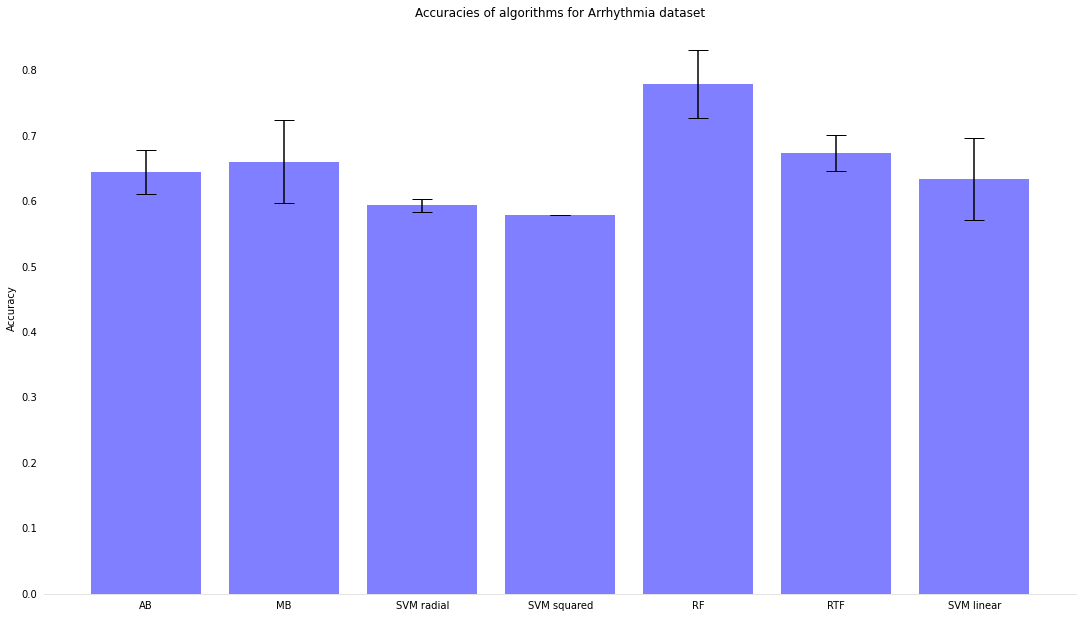

In [70]:
barchart(accuracies_dataset1, 'Arrhythmia')

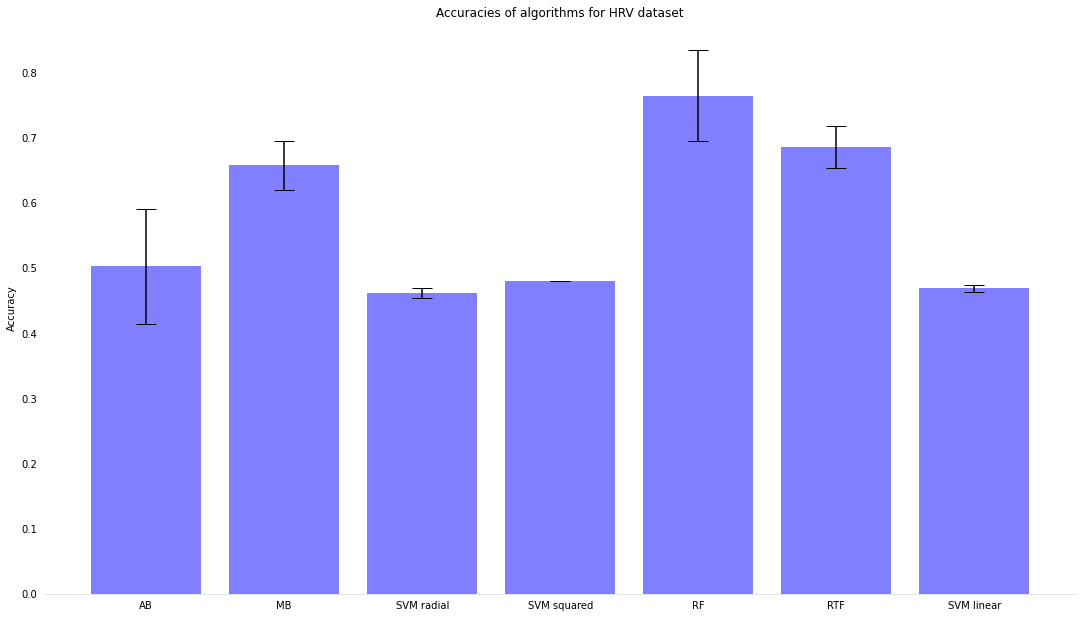

In [71]:
barchart(accuracies_dataset2, 'HRV')

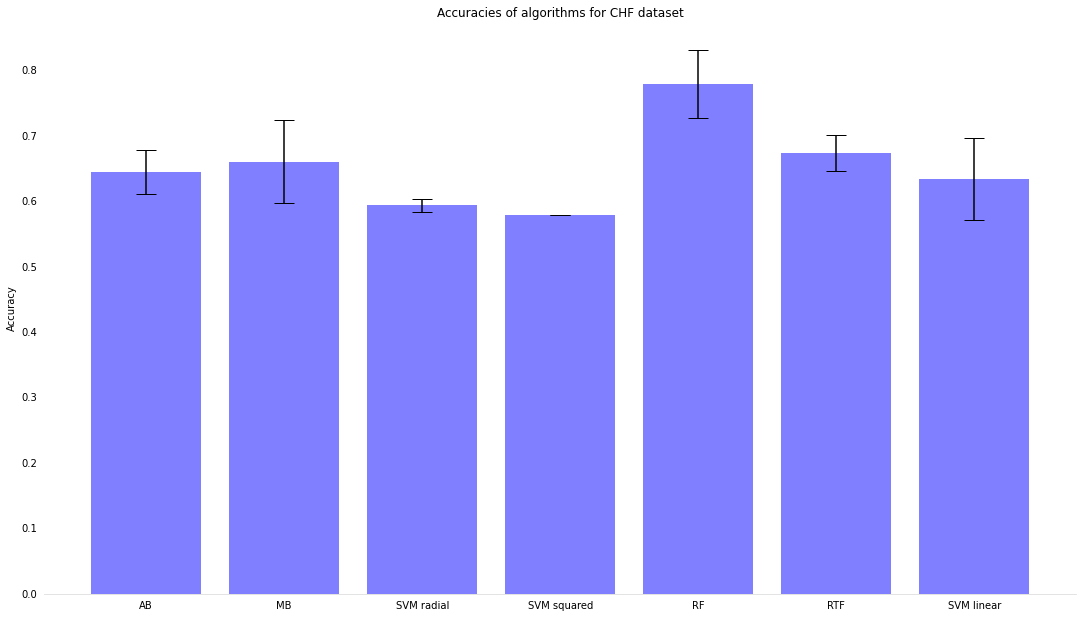

In [72]:
barchart(accuracies_dataset1, 'CHF')